# Code for generating Figure 2

## "Average learned distribution ($N = 100$) for a linear model with Gaussian features trained on different sample draws from a 1D data distribution $\{ -1, 0, 1\}$"

This Python notebook contains code for generating the second figure from the ICLR 2025 paper "[Generalization through variance: how noise shapes inductive biases in diffusion models](https://openreview.net/forum?id=7lUdo8Vuqa)". It depends on two files, `general_functions.py` and `linear_functions_1d.py`, that are in the `functions/` folder.

In [13]:
# imports
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import time

from functions.general_functions import get_time_funcs, get_basic_distributions_1d
from functions.linear_functions_1d import phi_gauss, phi_fourier, get_phi_crossed_func_1d, get_phi_crossed_grid_1d  # feature functions
from functions.linear_functions_1d import train_phi_denoise, sample_PF_ODE_1d, sample_PF_ODE_1d_batched                          # training and sampling

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<center>
<img src="fig2_gap_filling.png" width="1000"/></center>

Average learned distribution ($N = 100$) for a linear model with Gaussian features trained on different sample draws from a 1D data distribution $\{ -1, 0, 1\}$. Red: average learned distribution; black: true distribution; gray: PF-ODE approximation of true distribution. Different values of the time cutoff $\epsilon$ and ratio $F/P$ are shown. Note that there is more generalization as both become larger.

--------

Set up parameter choices.

In [15]:
eps_list = np.array([1e-4, 1e-3, 1e-2]); num_eps = len(eps_list)   # eps values to consider
P_list = np.array([64, 128, 256, 512, 1024]); num_P = len(P_list)  # P (number of training samples) values to consider


num_models = 100          # number of linear models to 'train'
num_samples = int(1e5)    # number of samples to draw per trained model, used to visualize learned distribution


# number of features
F_x = 16              # number of x features
F_t = 16              # number of t features
F_ = np.array([F_x, F_t])
F = F_x*F_t     # = 16 x 16 = 256 features


# define data distribution as list of x-y pairs
x_data = np.array([-1,-0, 1])


# define grid of x values, used for sampling and visualization
num_x = 200; x_min = -1.5; x_max = 1.5
x = np.linspace(x_min, x_max, num_x); dx = x[1] - x[0]
bins_x = np.linspace(x_min - dx/2., x_max + dx/2., num_x + 1)

Train many linear models, store info about them for later visualization.

In [17]:
x_list = np.zeros((num_eps, num_P, num_models, num_samples))

prob_emp_list = np.zeros((num_eps, num_P, num_models, num_x))
prob_avg_list = np.zeros((num_eps, num_P, num_x))
prob_std_list = np.zeros((num_eps, num_P, num_x))
prob_lower_list = np.zeros((num_eps, num_P, num_x))
prob_upper_list = np.zeros((num_eps, num_P, num_x))

start = time.perf_counter()
for r in range(num_eps):
    for c in range(num_P):
        print(r, c)
        eps = eps_list[r]
    
        # define forward process and noise schedule 
        beta_min, beta_d = 0.1, 19.9; rho = 7; params_time = {'beta_min':beta_min, 'beta_d':beta_d, 'rho':rho}
        T, num_tsteps = 1, 30
        t, t_lin, time_funcs = get_time_funcs(eps, T, num_tsteps, params_time, option='VP')
        dt_naive = (T - eps)/num_tsteps; #print(dt_naive)
    
        # get features
        feature_type = 'gauss'
        if feature_type == 'fourier':
            phi_x_func = lambda x : phi_fourier(x, F_x, x_min, x_max)
            phi_t_func = lambda t : phi_fourier(t, F_t, eps, T)
        elif feature_type == 'gauss':
            x_proto = np.linspace(x_min, x_max, F_x); dx_proto = x_proto[1] - x_proto[0]
            t_proto = np.linspace(eps, T, F_t); dt_proto = t_proto[1] - t_proto[0]
        
            phi_x_func = lambda a : phi_gauss(a, x_proto, dx_proto*np.ones_like(x_proto)/2., sig_scale=1.)
            phi_t_func = lambda a : phi_gauss(a, t_proto, dt_proto*np.ones_like(t_proto)/2., sig_scale=1.)
            
        phi_funcs = (phi_x_func, phi_t_func)
        phi_func = lambda x, t : get_phi_crossed_func_1d(x, t, phi_funcs, F)
        phi_grid = get_phi_crossed_grid_1d(x, t, phi_funcs, F)
        print(phi_grid.shape)
    
        # 'train' a linear denoising model, use analytic result instead of gradient descent
        W, Sig_phi, A_phi = train_phi_denoise(x_data, phi_func, P_list[c], num_models, time_funcs, eps_reg=0.1)
        mu_est = np.dot( W  ,(phi_grid.transpose(0, 2, 1)))
        print('computed mu est')
    
        # get samples
        x_t = sample_PF_ODE_1d_batched(num_samples, x, t, time_funcs, mu_est)
        print('got samples')

        # get histograms
        prob_emp = np.zeros((num_models, num_x))
        for j in range(num_models):
            prob_emp[j], _ = np.histogram(x_t[j], bins=bins_x, density=True)
        prob_avg = np.mean(prob_emp, axis=0)               # pointwise average learned distribution
        prob_std = np.std(prob_emp, axis=0)                # pointwise standard deviation of learned distribution

        prob_lower = np.quantile(prob_emp, 0.25, axis=0)   # 0.25 quantile
        prob_upper = np.quantile(prob_emp, 0.75, axis=0)   # 0.75 quantile
        print('got histograms')

        # store relevant info
        x_list[r,c] = x_t
        prob_emp_list[r, c] = prob_emp
        prob_avg_list[r, c] = prob_avg
        prob_std_list[r, c] = prob_std
        prob_lower_list[r, c] = prob_lower
        prob_upper_list[r, c] = prob_upper
        print()
print('Done!')
end = time.perf_counter()
print('Elapsed time: ', end - start)

0 0
(200, 31, 256)
start phi samples
got phi samples
Sig_phi shape:  (100, 256, 256)
A_phi shape:  (100, 1, 256)
computed empirical matrices
inverted cov
computed W
computed mu est
got samples
got histograms

0 1
(200, 31, 256)
start phi samples
got phi samples
Sig_phi shape:  (100, 256, 256)
A_phi shape:  (100, 1, 256)
computed empirical matrices
inverted cov
computed W
computed mu est
got samples
got histograms

0 2
(200, 31, 256)
start phi samples
got phi samples
Sig_phi shape:  (100, 256, 256)
A_phi shape:  (100, 1, 256)
computed empirical matrices
inverted cov
computed W
computed mu est
got samples
got histograms

0 3
(200, 31, 256)
start phi samples
got phi samples
Sig_phi shape:  (100, 256, 256)
A_phi shape:  (100, 1, 256)
computed empirical matrices
inverted cov
computed W
computed mu est
got samples
got histograms

0 4
(200, 31, 256)
start phi samples
got phi samples
Sig_phi shape:  (100, 256, 256)
A_phi shape:  (100, 1, 256)
computed empirical matrices
inverted cov
computed W

Get true scores and PF-ODE-derived score approximations for comparison.

In [21]:
# get true scores
prob_true_list = np.zeros((num_eps, num_P, num_x))
prob_almost_true_list = np.zeros((num_eps, num_P, num_x))
for r in range(num_eps):
    for c in range(num_P):
        print(r, c)
        eps = eps_list[r]

        # define forward process and noise schedule (same as 1d case)
        beta_min, beta_d = 0.1, 19.9; rho = 7; params_time = {'beta_min':beta_min, 'beta_d':beta_d, 'rho':rho}
        T, num_tsteps = 1, 30
        t, t_lin, time_funcs = get_time_funcs(eps, T, num_tsteps, params_time, option='VP')
        dt_naive = (T - eps)/num_tsteps; #print(dt_naive)

        alpha_t, sig_sq_t = time_funcs['alpha_t'], time_funcs['sig_sq_t']
        a_last, sig_last = alpha_t[-1], np.sqrt(sig_sq_t[-1])

        # Compute relevant distributions
        x_ = x[:,None]; x_data_ = x_data[None,:]
        x_data_norm = norm.pdf(x_, loc=x_data_*a_last, scale=sig_last)   # shape: (num_x, num_data)
        prob_t = np.mean(x_data_norm, axis=-1)              # shape: (num_x)

        prob_true_list[r, c] = prob_t

        dists = get_basic_distributions_1d(x_data, x, time_funcs)
        mu_true = dists['mu_bayes']

        # get samples
        x_t = sample_PF_ODE_1d(10*num_samples, x, t, time_funcs, mu_true)
        print('got samples')

        prob_emp, _ = np.histogram(x_t, bins=bins_x, density=True)
        prob_almost_true_list[r, c] = prob_emp
        print()
print('Done!')

0 0
got samples

0 1
got samples

0 2
got samples

0 3
got samples

0 4
got samples

1 0
got samples

1 1
got samples

1 2
got samples

1 3
got samples

1 4
got samples

2 0
got samples

2 1
got samples

2 2
got samples

2 3
got samples

2 4
got samples

Done!


Plot figure.

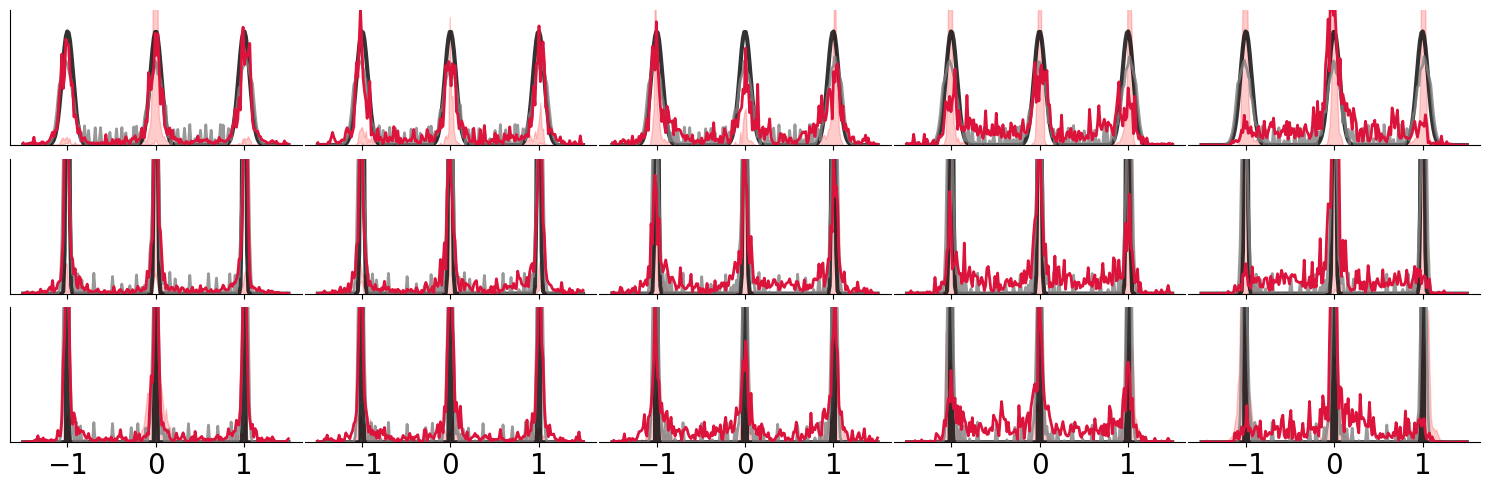

In [23]:
lw = 2

fig, ax = plt.subplots(ncols=num_P, nrows=num_eps, figsize=(15,5), sharex=True, sharey=True)

for r in range(num_eps):
    for c in range(num_P):
        r_ = num_eps - 1 - r   # decided to change order:  bottom to top, increasing eps
        c_ = num_P - 1 - c     # left to right, increasing F/P
        ax[r, c].plot(x, prob_true_list[r_,c_], color='black', linewidth=lw+1, alpha=0.8)
        ax[r, c].plot(x, prob_almost_true_list[r_, c_], color='gray', linewidth=lw, alpha=0.8)
        ax[r, c].plot(x, prob_avg_list[r_,c_], color='crimson', linewidth=lw,zorder=3)
        ax[r, c].fill_between(x, prob_lower_list[r_,c_], prob_upper_list[r,c], color='red', alpha=0.2)

        ax[r, c].spines['top'].set_visible(False)
        ax[r, c].spines['right'].set_visible(False)
        if c > 0:
            ax[r, c].spines['left'].set_visible(False)
            ax[r, c].set_yticks([])
        ax[r, c].tick_params(axis='both', which='major', labelsize=20)
        ax[r, c].tick_params(axis='both', which='minor', labelsize=20)
        ax[r, c].set_ylim(0, 2.5)
plt.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0.1)

plt.savefig('results/fig-gap-filling'+'.png', bbox_inches='tight', transparent=True)
plt.savefig('results/fig-gap-filling'+'.pdf', bbox_inches='tight', transparent=True)
plt.savefig('results/fig-gap-filling'+'.svg', bbox_inches='tight', transparent=True)
plt.show()